In [68]:
import pickle
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from tqdm.auto import tqdm
from joblib import Parallel, delayed
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

## Define required downloads

In [20]:
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/jonashoffmann/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jonashoffmann/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/jonashoffmann/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Define the seasons as a dict
By defining each season to its corresponding dataframe, we can get a proper name corresponding to the data.

In [21]:
season_to_episodes_df = {
    "Indigo League": "indigo_df.pkl",
    "Orange Islands": "orange_df.pkl",
    "Johto": "johto_df.pkl",
    "Pocket Monsters": "pocket_monsters.pkl",
    "Hoenn": "hoenn_df.pkl",
    "XY": "xy_df.pkl",
    "Black & White": "black_df.pkl",
    "Sun & Moon": "sun_df.pkl",
    "Diamond & Pearl": "diamond_df.pkl",
}

season_to_graph_paths = {
    "Indigo League": "indigo_G.pkl",
    "Orange Islands": "orange_G.pkl",
    "Johto": "johto_G.pkl",
    "Pocket Monsters": "journeys_G.pkl",
    "Hoenn": "hoenn_G.pkl",
    "XY": "kalos_G.pkl",
    "Black & White": "unova_G.pkl",
    "Sun & Moon": "alola_G.pkl",
    "Diamond & Pearl": "sinnoh_G.pkl",
    "All seasons": "all_seasons_G.pkl",
}

## Load and combine the data
We are going to create a large dataframe, with an added season column, such that it is easier to analyze the data.

In [22]:
season_to_dfs = {k: pd.read_pickle(v) for k, v in season_to_episodes_df.items()}

# Add the season column
for season, df in season_to_dfs.items():
    df["season"] = season

# Create the combined dataframe
all_df = pd.concat(season_to_dfs.values(), ignore_index=True)

print("Total number of episodes:", len(all_df))
all_df.head()

Total number of episodes: 1173


,pokemon,plot,season
0,"[Pikachu, Mankey, Spearow, Gyarados, Hypnosis,...",Pokémon - I Choose You! (Japanese: ポケモン！きみにきめた...,Indigo League
1,"[Goldeen, Pikachu, Rattata, Jigglypuff, Caterp...",Ash rushes into Viridian City with his gravely...,Indigo League
2,"[Pikachu, Caterpie, Beedrill, Ekans, Pidgeotto...",Ash discovers and catches a Caterpie—his first...,Indigo League
3,"[Pikachu, Bulbasaur, Charmander, Beedrill, Pin...",Misty and Ash continue to wander the Viridian ...,Indigo League
4,"[Geodude, Pikachu, Pidgeotto, Meowth, Butterfr...","Jessie, James, and Meowth dig a trap for our h...",Indigo League


## Preliminary analysis of seasons
Here we are going to create a bar plot of the number of episodes per season.

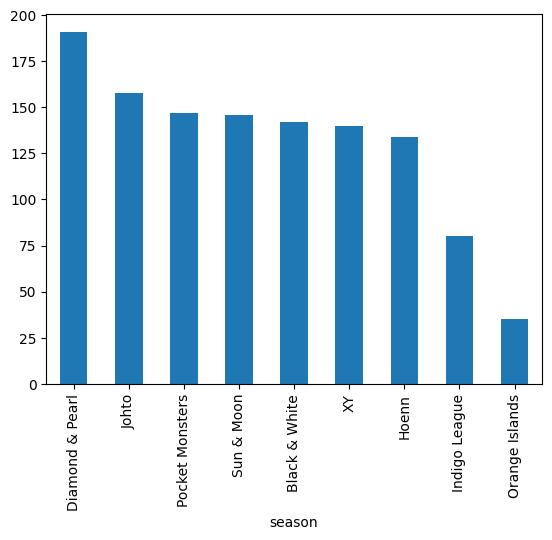

In [23]:
plt.figure()
season_counts = all_df["season"].value_counts()
season_counts.plot.bar()
plt.show()

## Load the graph for the anime

In [24]:
season_to_graphs = {}
for season, path in season_to_graph_paths.items():
    with open(f"graphs/{path}", "rb") as f:
        season_to_graphs[season] = pickle.load(f)

for season, graph in season_to_graphs.items():
    print(f"{season}:")
    print("Number of nodes:", len(graph.nodes()))
    print("Number of edges:", len(graph.edges()))
    print()

Indigo League:
Number of nodes: 151
Number of edges: 5193

Orange Islands:
Number of nodes: 132
Number of edges: 3320

Johto:
Number of nodes: 254
Number of edges: 10669

Pocket Monsters:
Number of nodes: 689
Number of edges: 52993

Hoenn:
Number of nodes: 363
Number of edges: 15046

XY:
Number of nodes: 434
Number of edges: 21053

Black & White:
Number of nodes: 321
Number of edges: 12558

Sun & Moon:
Number of nodes: 452
Number of edges: 28531

Diamond & Pearl:
Number of nodes: 448
Number of edges: 20615

All seasons:
Number of nodes: 845
Number of edges: 117813



## Create a dataframe with the pokemon and their communities with a season column
Load the pokemon communities and create a dataframe with the pokemon and their communities.

In [25]:
season_to_pokemon_communities = {}
for season, graph in season_to_graphs.items():
    nodes = graph.nodes(data=True)
    season_to_pokemon_communities[season] = pd.DataFrame(
        [[pokemon, data["group"], season] for pokemon, data in nodes],
        columns=["pokemon", "community", "season"],
    )

# Combine the dataframes
all_pokemon_communities_df = pd.concat(
    season_to_pokemon_communities.values(), ignore_index=True
)

print("Total number of pokemon (non-unique):", len(all_pokemon_communities_df))
all_pokemon_communities_df

Total number of pokemon (non-unique): 4089


,pokemon,community,season
0,Pikachu,0,Indigo League
1,Mankey,3,Indigo League
2,Spearow,2,Indigo League
3,Gyarados,0,Indigo League
4,Nidorino,3,Indigo League
...,...,...,...
4084,Dubwool,1,All seasons
4085,Perrserker,1,All seasons
4086,Flapple,3,All seasons
4087,Hatenna,4,All seasons


## Create the tokenizer
We are going to create a tokenizer that will tokenize the text, remove stopwords and lemmatize the words, such that we can get a better understanding of the words used in the plot.

In [66]:
import unicodedata
from typing import Optional, Callable


def get_tokenizer(stopwords: set[str], lemmatizer: Optional[nltk.WordNetLemmatizer] = None) -> Callable:
    def tokenizer(
        text: str
    ) -> str:
        # Split the text into words
        word_tokens = nltk.word_tokenize(text)

        # Remove all accents and special characters and convert it to ascii
        word_tokens = [
            unicodedata.normalize("NFKD", word).encode("ascii", "ignore").decode("utf-8")
            for word in word_tokens
        ]

        # Then remove all stopwords
        tokens = [
            word.lower()
            for word in word_tokens
            if word.isalpha() and word.lower() not in stopwords
        ]

        # Then lemmatize the words
        if lemmatizer is not None:
            tokens = [lemmatizer.lemmatize(token) for token in tokens]

        return tokens

    return tokenizer

In [67]:
stopwords = set(nltk.corpus.stopwords.words("english"))
lemmatizer = nltk.WordNetLemmatizer()
tokenizer = get_tokenizer(stopwords, lemmatizer)

all_df["tokens"] = Parallel(n_jobs=-1)(
    delayed(tokenizer)(plot) for plot in tqdm(all_df["plot"])
)

  0%|          | 0/1173 [00:00<?, ?it/s]

In [51]:
season_names = list(season_to_dfs.keys())
season_to_tokens = {}
for season in season_names:
    season_to_tokens[season] = all_df[all_df["season"] == season]["tokens"].sum()

# number of unique tokens per season
for season, tokens in season_to_tokens.items():
    print(f"{season}: {len(set(tokens))}")

Indigo League: 5572
Orange Islands: 3168
Johto: 7788
Pocket Monsters: 7513
Hoenn: 7471
XY: 6992
Black & White: 7928
Sun & Moon: 7285
Diamond & Pearl: 8547


## Plot the ZIPF distribution for each season

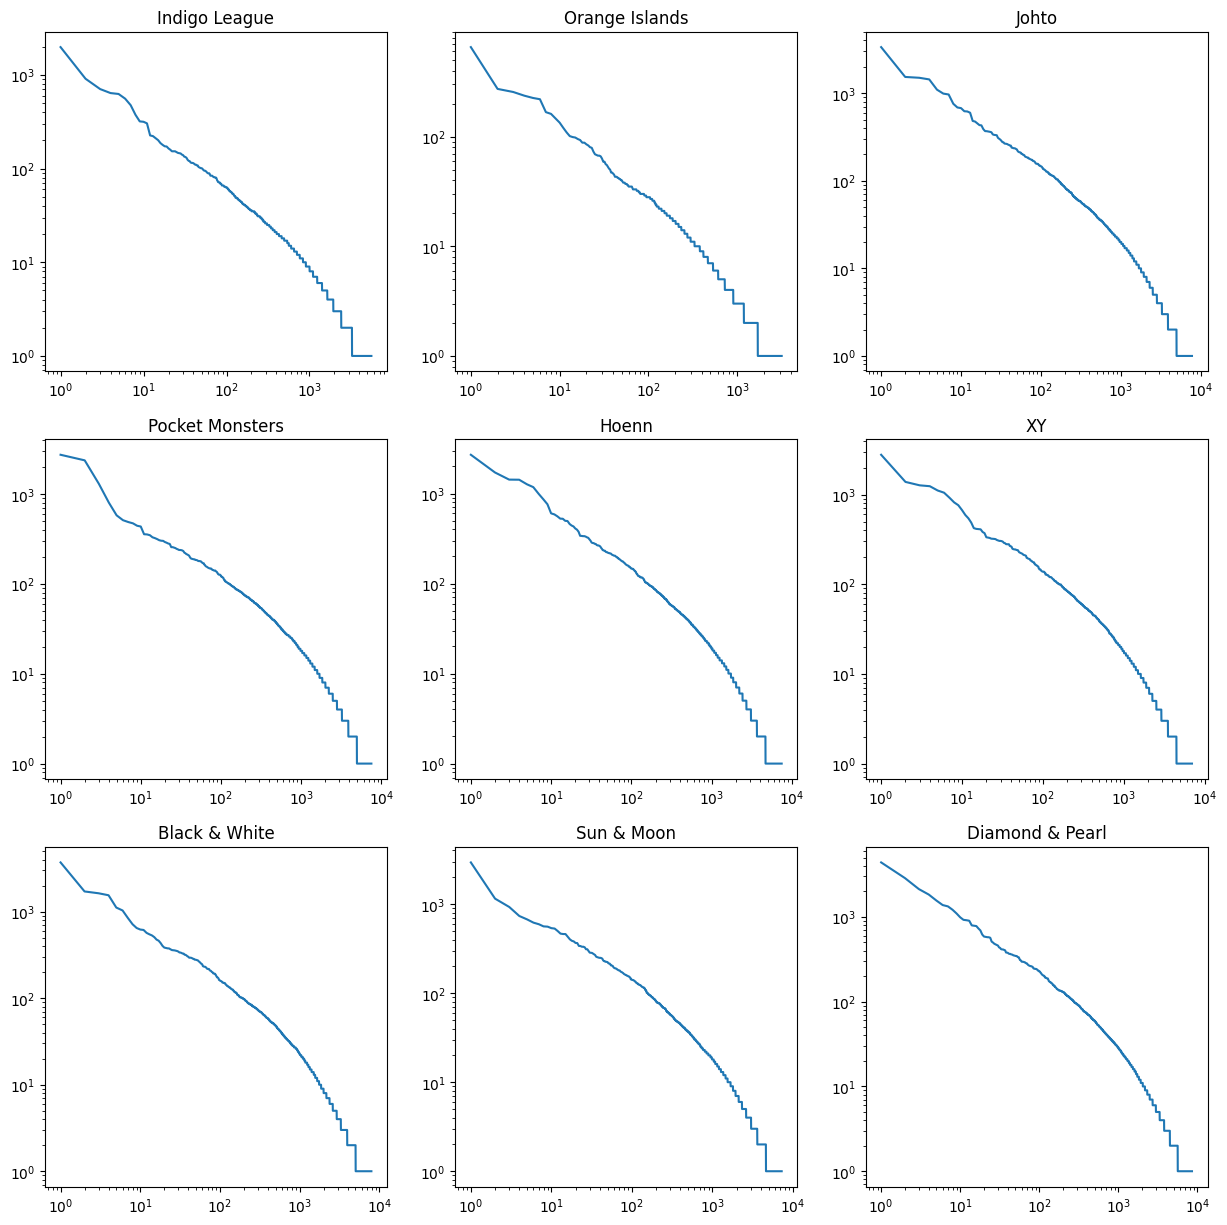

In [52]:
def plot_zipf(tokens, ax):
    fdist = nltk.FreqDist(tokens)
    most_common = fdist.most_common()

    x = np.arange(1, len(most_common) + 1)
    y = [freq for word, freq in most_common]

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.plot(x, y)


# Plot the ZIPF distribution for each season in a grid
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i, season in enumerate(season_names):
    ax = axs[i // 3, i % 3]
    ax.set_title(season)
    plot_zipf(season_to_tokens[season], ax=ax)
plt.show()

## Create the bigrams for each season
Bigrams are pairs of words that are next to each other in the text. We are going to create a list of bigrams for each season. Then we are going to sum all the tokens for each season, such that we can use it to create contingency tables later.

In [53]:
def get_bigrams(tokens):
    return list(nltk.bigrams(tokens))


# Set the bigrams for the dataframe
all_df["bigrams"] = [get_bigrams(tokens) for tokens in all_df["tokens"]]

season_to_bigrams = {}
for season in season_names:
    season_to_bigrams[season] = all_df[all_df["season"] == season]["bigrams"].sum()

all_df.head()

,pokemon,plot,season,tokens,bigrams
0,"[Pikachu, Mankey, Spearow, Gyarados, Hypnosis,...",Pokémon - I Choose You! (Japanese: ポケモン！きみにきめた...,Indigo League,"[pokemon, choose, japanese, pokemon, choose, f...","[(pokemon, choose), (choose, japanese), (japan..."
1,"[Goldeen, Pikachu, Rattata, Jigglypuff, Caterp...",Ash rushes into Viridian City with his gravely...,Indigo League,"[ash, rush, viridian, city, gravely, wounded, ...","[(ash, rush), (rush, viridian), (viridian, cit..."
2,"[Pikachu, Caterpie, Beedrill, Ekans, Pidgeotto...",Ash discovers and catches a Caterpie—his first...,Indigo League,"[ash, discovers, catch, caterpiehis, first, po...","[(ash, discovers), (discovers, catch), (catch,..."
3,"[Pikachu, Bulbasaur, Charmander, Beedrill, Pin...",Misty and Ash continue to wander the Viridian ...,Indigo League,"[misty, ash, continue, wander, viridian, fores...","[(misty, ash), (ash, continue), (continue, wan..."
4,"[Geodude, Pikachu, Pidgeotto, Meowth, Butterfr...","Jessie, James, and Meowth dig a trap for our h...",Indigo League,"[jessie, james, meowth, dig, trap, hero, end, ...","[(jessie, james), (james, meowth), (meowth, di..."


## Create the contingency tables for each season
A contingency table is used to calculate the chi-squared value for a bigram. The chi-squared value is used to determine whether a bigram is statistically significant or not. Which in turn can be used to determine whether a bigram is a collocation or not. A collocation is a bigram that is used more often than expected by chance.

The formula for the contingency table is as follows:
$$
\begin{array}{|c|c|c|}
\hline & \text { word } & \text { not word } \\
\hline \text { word } & n_{i i} & n_{i o} \\
\hline \text { not word } & n_{o i} & n_{o o} \\
\hline
\end{array}
$$
where:
- $n_{ii}$ is the number of times the bigram occurs.
- $n_{io}$ is the number of times the first word occurs without the second word.
- $n_{oi}$ is the number of times the second word occurs without the first word.
- $n_{oo}$ is the number of times neither of the words occur.

In [54]:
def contingency_table(bigram, all_bigrams_count, unique_words, n_bigrams):
    """
    Create a contingency table for a bigram.

    :param bigram: The bigram to create the contingency table for.
    :param all_bigrams_count: A dictionary containing the count of all bigrams.
    :param unique_words: A set of all unique words.
    :param n_bigrams: The total number of bigrams.

    :return: A contingency table for the bigram and the bigram itself.
    """

    # Count number of times the bigram occurs
    n_ii = all_bigrams_count[bigram]

    n_io = 0
    n_oi = 0

    # Count number of times the first word occurs without the second word
    # by looping over the unique words.
    for other in unique_words:
        if other != bigram[1]:
            n_io += all_bigrams_count[(bigram[0], other)]
        if other != bigram[0]:
            n_oi += all_bigrams_count[(other, bigram[1])]

    # Finally, calculate the number of times neither of the words occur
    n_oo = n_bigrams - n_ii - n_io - n_oi
    return np.array([[n_ii, n_io], [n_oi, n_oo]]), bigram


# Calculate the contingency table for each season
with Parallel(n_jobs=-1) as parallel:
    season_to_contingency_tables = {}
    for season in season_names:
        all_bigrams = season_to_bigrams[season]
        all_bigrams_count = Counter(all_bigrams)
        unique_words = set(all_df[all_df["season"] == season]["tokens"].sum())

        season_to_contingency_tables[season] = parallel(
            delayed(contingency_table)(
                bg, all_bigrams_count, unique_words, len(season_to_bigrams[season])
            )
            for bg in tqdm(
                set(all_bigrams),
                desc=f"Calculating contingency tables for {season}",
            )
        )

Calculating contingency tables for Indigo League:   0%|          | 0/34946 [00:00<?, ?it/s]

Calculating contingency tables for Orange Islands:   0%|          | 0/14260 [00:00<?, ?it/s]

Calculating contingency tables for Johto:   0%|          | 0/74284 [00:00<?, ?it/s]

Calculating contingency tables for Pocket Monsters:   0%|          | 0/66988 [00:00<?, ?it/s]

Calculating contingency tables for Hoenn:   0%|          | 0/72246 [00:00<?, ?it/s]

Calculating contingency tables for XY:   0%|          | 0/67984 [00:00<?, ?it/s]

Calculating contingency tables for Black & White:   0%|          | 0/81754 [00:00<?, ?it/s]

Calculating contingency tables for Sun & Moon:   0%|          | 0/68699 [00:00<?, ?it/s]

Calculating contingency tables for Diamond & Pearl:   0%|          | 0/101295 [00:00<?, ?it/s]

In [48]:
print(sum(len(tables) for tables in season_to_contingency_tables.values()))

581193


## Calculate the $p$-values for each bigram with the chi-squared test
The $p$-values are calculated from the previously calculated contingency tables. Here we will use the $p$-value to find the statistically significant bigrams. We will use a significance level of 0.001, which means that we will find the bigrams that occur more often than expected by chance in 0.1% of the cases.

In [55]:
def calc_pvalue(contingency_table, bigram):
    """
    Calculate the p-value for a contingency table.

    :param contingency_table: The contingency table to calculate the p-value for.

    :return: The p-value for the contingency table and the bigram.
    """
    return chi2_contingency(contingency_table).pvalue, bigram

# Calculate p-values for each season
with Parallel(n_jobs=-1) as parallel:
    season_to_p_values = {}
    for season in season_names:
        season_to_p_values[season] = parallel(
            delayed(calc_pvalue)(contingency_table, bigram)
            for contingency_table, bigram in tqdm(
                season_to_contingency_tables[season],
                desc=f"Calculating p-values for {season}",
            )
        )

Calculating p-values for Indigo League:   0%|          | 0/34946 [00:00<?, ?it/s]

Calculating p-values for Orange Islands:   0%|          | 0/14260 [00:00<?, ?it/s]

Calculating p-values for Johto:   0%|          | 0/74284 [00:00<?, ?it/s]

Calculating p-values for Pocket Monsters:   0%|          | 0/66988 [00:00<?, ?it/s]

Calculating p-values for Hoenn:   0%|          | 0/72246 [00:00<?, ?it/s]

Calculating p-values for XY:   0%|          | 0/67984 [00:00<?, ?it/s]

Calculating p-values for Black & White:   0%|          | 0/81754 [00:00<?, ?it/s]

Calculating p-values for Sun & Moon:   0%|          | 0/68699 [00:00<?, ?it/s]

Calculating p-values for Diamond & Pearl:   0%|          | 0/101295 [00:00<?, ?it/s]

In [57]:
# Create a dictionary of season to bigrams and their p-values
season_to_pvalues_df = {k: pd.DataFrame(v, columns=["p_value", "bigram"]) for k, v in season_to_p_values.items()}

# Create a combined dataframe for all seasons with bigrams and their p-values and season as a column
bigrams_pvalues_df = pd.concat(season_to_pvalues_df.values(), keys=season_to_pvalues_df.keys())
bigrams_pvalues_df.reset_index(inplace=True)
bigrams_pvalues_df.rename(columns={"level_0": "season"}, inplace=True)
bigrams_pvalues_df.drop(columns=["level_1"], inplace=True)

# Sort the dataframe by p-value
bigrams_pvalues_df.sort_values("p_value", inplace=True, ascending=True)
print(f"Number of bigrams: {len(bigrams_pvalues_df)}")

Number of bigrams: 582456


In [65]:
# Print the top 10 bigrams with the lowest p-values for each season
# and print the number of bigrams with a p-value lower than 0.001
for season in season_names:
    season_pvalue_df = bigrams_pvalues_df[bigrams_pvalues_df["season"] == season]
    n_bigrams_with_low_pvalue = len(season_pvalue_df[season_pvalue_df["p_value"] < 0.001])
    n_bigrams = len(season_pvalue_df)
    percent_of_bigrams = n_bigrams_with_low_pvalue / n_bigrams * 100

    print(f"Season: {season}")
    print(f"Number of bigrams with p-value < 0.001: {n_bigrams_with_low_pvalue}")
    print(f"Number of bigrams: {n_bigrams:,}")
    print(f"Percent of bigrams with p-value < 0.001: {percent_of_bigrams:.2f}%")
    print()
    print("Top 10 bigrams:")
    for i, row in season_pvalue_df.head(10).iterrows():
        print(f"{row['bigram']}: {row['p_value']:.8f}")

    print()
    print()

Season: Indigo League
Number of bigrams with p-value < 0.001: 21822
Number of bigrams: 34,946
Percent of bigrams with p-value < 0.001: 62.44%

Top 10 bigrams:
('returning', 'civilization'): 0.00000000
('mysterious', 'patron'): 0.00000000
('sleep', 'powder'): 0.00000000
('demonstrate', 'importance'): 0.00000000
('consults', 'pokedex'): 0.00000000
('wing', 'teaching'): 0.00000000
('akihabara', 'porygon'): 0.00000000
('plank', 'linking'): 0.00000000
('keep', 'quiet'): 0.00000000
('correctly', 'pleasing'): 0.00000000


Season: Orange Islands
Number of bigrams with p-value < 0.001: 9364
Number of bigrams: 14,260
Percent of bigrams with p-value < 0.001: 65.67%

Top 10 bigrams:
('grown', 'considerably'): 0.00000000
('perfectly', 'carve'): 0.00000000
('cable', 'car'): 0.00000000
('awake', 'feeling'): 0.00000000
('refreshed', 'spirit'): 0.00000000
('giovanni', 'maintained'): 0.00000000
('resembles', 'microphone'): 0.00000000
('forcefully', 'erupts'): 0.00000000
('sleepy', 'culprit'): 0.00000000

As we can see the percentage of bigrams with a p-value < $0.001$ is quite high. The season with the lowest number of significant collocations is _Diamond & Pearl_, which is curious since it is also the one with the largest number of bigrams present. Coincidentally, the season with the lowest number of bigrams, _Orange Islands_, is the one with the highest ratio of significant bigrams. This is probably due to the fact that the season is quite short, and therefore the number of bigrams is also low.

If we look at the different seasons, we can see the significant collocations are quite different from season to season. They seem to contain themes fx, _Johto_ seems to have a seems to be centered around adjectives describing smells and feelings, while _Diamond & Pearl_ seems to be centered more around verbs.

## Run TF-IDF analysis on the plots per season
We will now run a TF-IDF analysis on the plots to find the most important words in each season. We will use the same tokenizer as previously. Then we are going to use the `TfidfVectorizer` from `sklearn` to calculate the TF-IDF values for each word. We will then use the TF-IDF values to create a word cloud for each season.

Season: Black & White
Top 5 words with highest TF-IDF score:
zweilous: 5.269697449699962
zoruato: 5.269697449699962
zoroarkwho: 5.269697449699962
zoroark: 5.269697449699962
zooming: 5.269697449699962



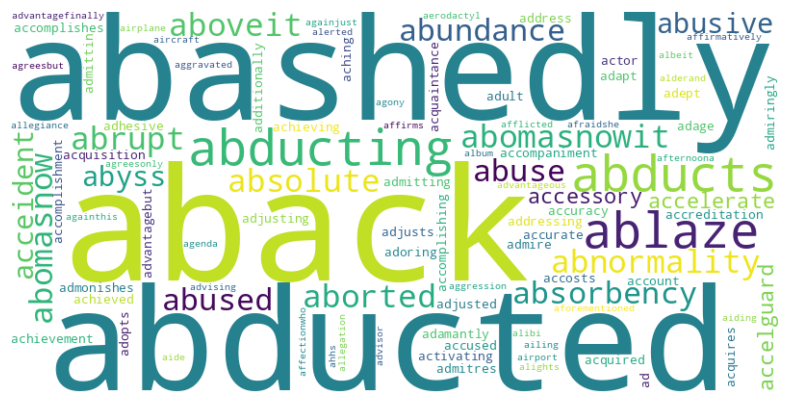

Season: Diamond & Pearl
Top 5 words with highest TF-IDF score:
zubat: 5.564348191467836
zooey: 5.564348191467836
zipping: 5.564348191467836
zipper: 5.564348191467836
zipline: 5.564348191467836



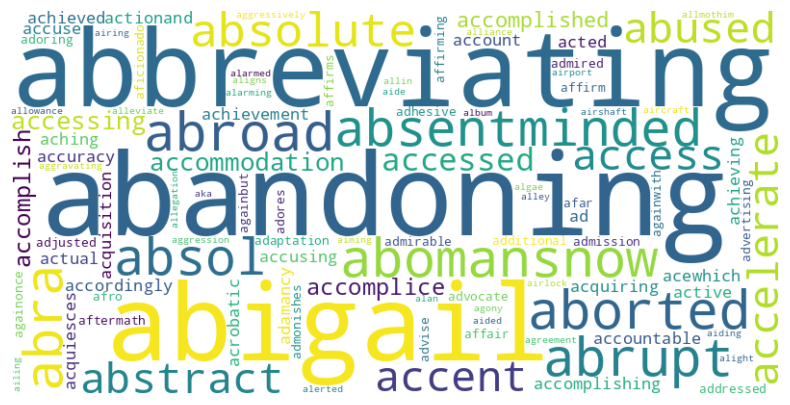

Season: Hoenn
Top 5 words with highest TF-IDF score:
zoned: 5.212127597878484
zone: 5.212127597878484
zipping: 5.212127597878484
zip: 5.212127597878484
zigzag: 5.212127597878484



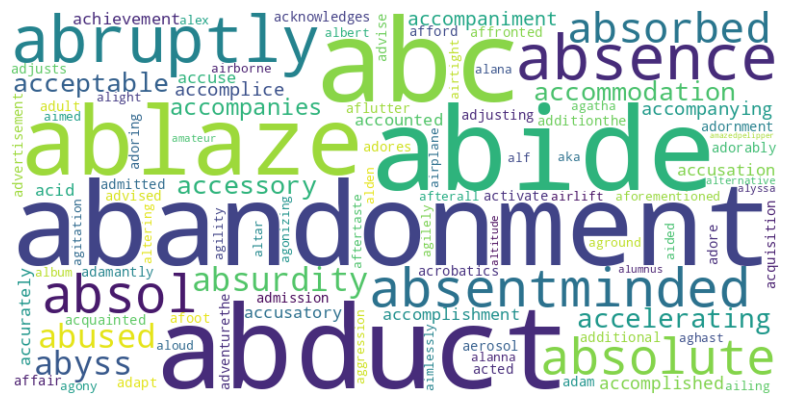

Season: Indigo League
Top 5 words with highest TF-IDF score:
zombie: 4.701301974112493
zapdos: 4.701301974112493
youth: 4.701301974112493
yes: 4.701301974112493
yellow: 4.701301974112493



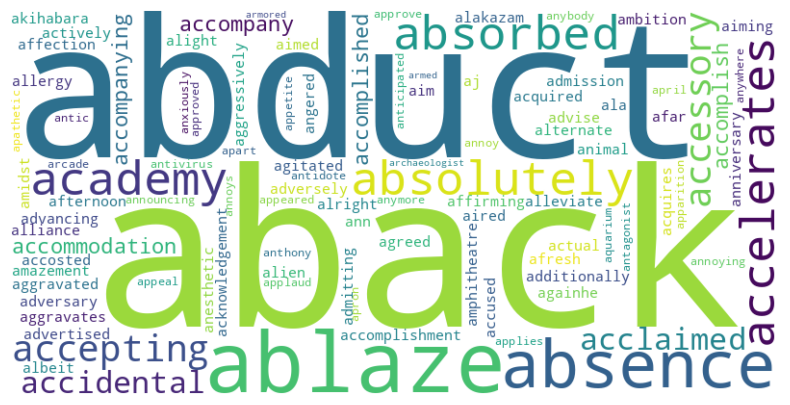

Season: Johto
Top 5 words with highest TF-IDF score:
zoom: 5.375757021660286
zeroing: 5.375757021660286
zero: 5.375757021660286
zephyr: 5.375757021660286
zapped: 5.375757021660286



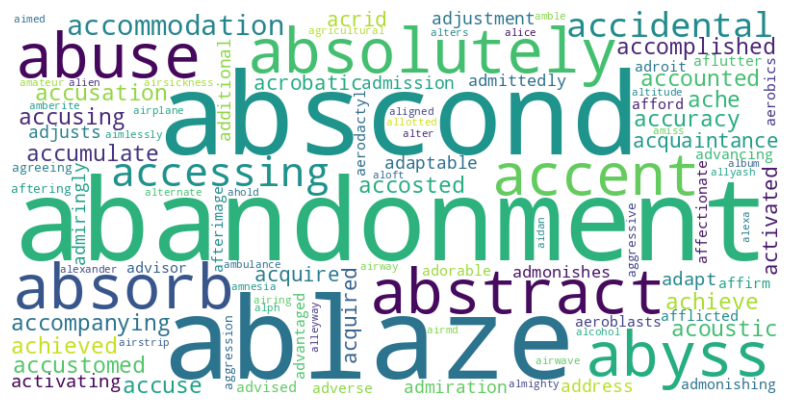

Season: Orange Islands
Top 5 words with highest TF-IDF score:
zone: 3.8903717578961645
youth: 3.8903717578961645
yard: 3.8903717578961645
yambera: 3.8903717578961645
writes: 3.8903717578961645



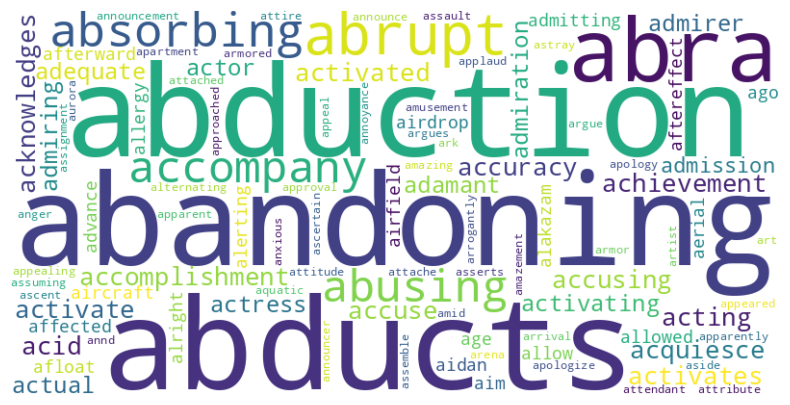

Season: Pocket Monsters
Top 5 words with highest TF-IDF score:
zoroark: 5.30406509320417
zooming: 5.30406509320417
zoned: 5.30406509320417
zombie: 5.30406509320417
zip: 5.30406509320417



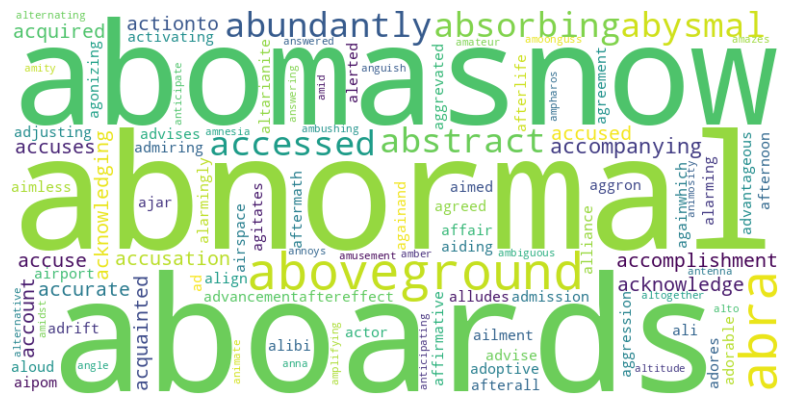

Season: Sun & Moon
Top 5 words with highest TF-IDF score:
zweilous: 5.297285406218791
zooming: 5.297285406218791
zoom: 5.297285406218791
zero: 5.297285406218791
zeraoracomes: 5.297285406218791



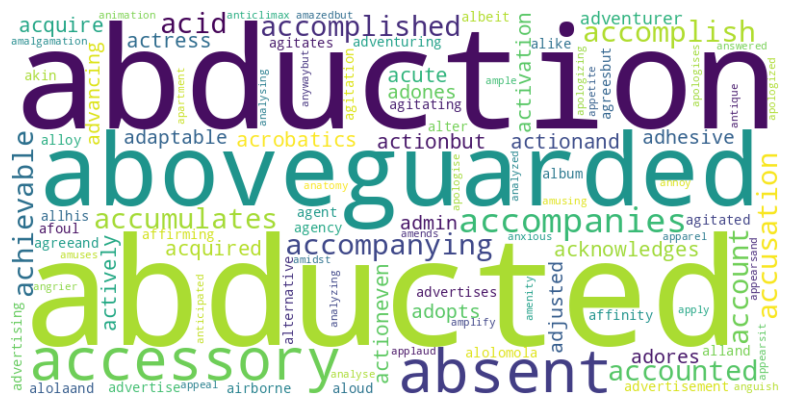

Season: XY
Top 5 words with highest TF-IDF score:
zygardebut: 5.255612709818223
zapping: 5.255612709818223
zapdoswho: 5.255612709818223
youngster: 5.255612709818223
yesterday: 5.255612709818223



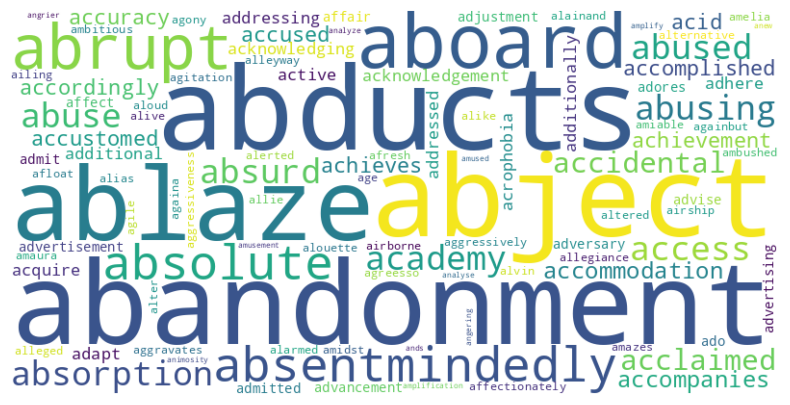

In [82]:
for season, season_df in all_df.groupby("season"):
    print(f"Season: {season}")
    tfidf = TfidfVectorizer(tokenizer=tokenizer, token_pattern=None)
    tfidf_matrix = tfidf.fit_transform(season_df["plot"])

    # Get the feature names (the words)
    feature_names = tfidf.get_feature_names_out()

    episode_scores = tfidf_matrix.sum(axis=0)
    episode_scores = np.squeeze(np.asarray(episode_scores))

    # Get the TF-IDF values for each word
    idf_scores = tfidf.idf_
    print("Top 5 words with highest TF-IDF score:")
    sorted_idf_scores = sorted(zip(idf_scores, feature_names), reverse=True)
    for score, ngram in sorted_idf_scores[:5]:
        print(f"{ngram}: {score}")
    print()

    wordcloud = WordCloud(
        background_color="white", max_words=100, width=800, height=400
    ).generate_from_frequencies(dict(zip(feature_names, idf_scores)))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

## Run TF-IDF analysis on the plots for all seasons per community
Now we are going to repeat the same process of creating wordclouds, but this time for each community.

In [ ]:
for season in season_names:
    print(f"Season: {season}")
    season_df = all_df[all_df["season"] == season].explode("pokemon")
    season_pokemon_community_df = all_pokemon_communities_df[
        all_pokemon_communities_df["season"] == season
    ]



    communities = season_pokemon_community_df["community"].unique()

    for community in communities:
        tfidf = TfidfVectorizer(tokenizer=tokenizer, token_pattern=None)
        tfidf_matrix = tfidf.fit_transform(season_df["plot"])

        # Get the feature names (the words)
        feature_names = tfidf.get_feature_names_out()

        episode_scores = tfidf_matrix.sum(axis=0)
        episode_scores = np.squeeze(np.asarray(episode_scores))

        # Get the TF-IDF values for each word
        idf_scores = tfidf.idf_
        print("Top 5 words with highest TF-IDF score:")
        sorted_idf_scores = sorted(zip(idf_scores, feature_names))
        for score, ngram in sorted_idf_scores[:5]:
            print(f"{ngram}: {score}")
        print()

        wordcloud = WordCloud(
            background_color="white", max_words=100, width=800, height=400
        ).generate_from_frequencies(dict(zip(feature_names, episode_scores)))
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()